# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utility Functions</a></div><div class="lev1 toc-item"><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Logistic Regression</a></div><div class="lev2 toc-item"><a href="#Linearly-Separable-Data" data-toc-modified-id="Linearly-Separable-Data-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Linearly Separable Data</a></div><div class="lev2 toc-item"><a href="#Complex-Data---Moons" data-toc-modified-id="Complex-Data---Moons-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Complex Data - Moons</a></div><div class="lev2 toc-item"><a href="#Complex-Data---Circles" data-toc-modified-id="Complex-Data---Circles-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Complex Data - Circles</a></div><div class="lev1 toc-item"><a href="#Training-a-Deep-Neural-Network" data-toc-modified-id="Training-a-Deep-Neural-Network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training a Deep Neural Network</a></div><div class="lev2 toc-item"><a href="#Complex-Data---Moons" data-toc-modified-id="Complex-Data---Moons-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Complex Data - Moons</a></div><div class="lev2 toc-item"><a href="#Complex-Data---Circles" data-toc-modified-id="Complex-Data---Circles-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Complex Data - Circles</a></div><div class="lev2 toc-item"><a href="#Complex-Data---Sine-Wave" data-toc-modified-id="Complex-Data---Sine-Wave-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Complex Data - Sine Wave</a></div><div class="lev1 toc-item"><a href="#Multiclass-Classification" data-toc-modified-id="Multiclass-Classification-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Multiclass Classification</a></div><div class="lev2 toc-item"><a href="#Softmax-Regression" data-toc-modified-id="Softmax-Regression-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Softmax Regression</a></div><div class="lev2 toc-item"><a href="#Deep-Neural-Network" data-toc-modified-id="Deep-Neural-Network-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Deep Neural Network</a></div>

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import seaborn as sns
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

#from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
#from keras.optimizers import Adam 
#ImportError: cannot import name 'Adam' from 'keras.optimizers'
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

# Utility Functions

These are the plotting helper functions used further down in the notebook. You don't need to fully understand what's going on here to get the big picture. The names of the functions are self-explanatory. I would at first recommend to skip this part and proceed to the next Logistic Regression section.

In [5]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    #Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = (model.predict(np.c_[xx.ravel(), yy.ravel()]) ).astype("int32")
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = (model.predict(X) > 0.5).astype("int32")
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Loss")
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")

    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

# Logistic Regression

Despite its name, logistic regression (LR) is a binary *classification* algorithm. It's the most popular technique for 0/1 classification. LR will try to draw a straight line to separate the classes, that's where the term *linear model* comes from. LR works on arbitrary dimensions, not just two. For 3 dimensional data it'll try to draw a 2 dimensional plane to separate the classes. This generalizes to N dimensional data and N-1 dimensional hyperplane separator. If you have a supervised binary classification problem, given an input data with multiple columns and a binary 0/1 outcome, LR is the first method to try. In this section we will focus on 2 dimensional data since it's easier to visualize, and in the later sections we will work with multidimensional input.

## Linearly Separable Data

First let's start with the easy example. 2 dimensional linearly separable data. We are using the scikit-learn *make_classification* method to generate our data and use our helper function defined above to visualize it.

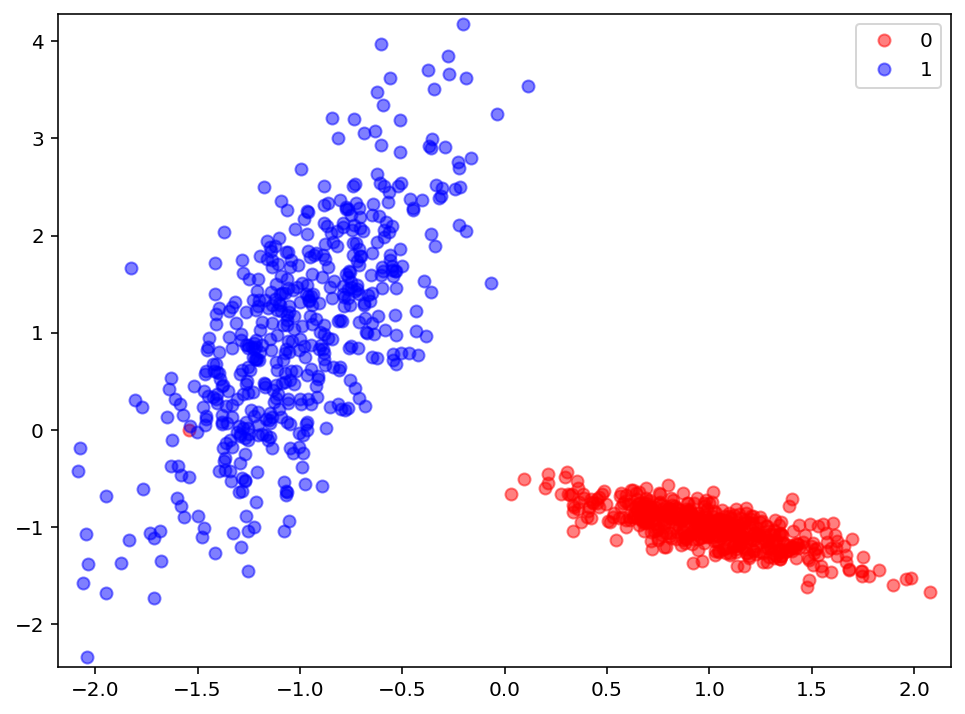

In [6]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                           n_informative=2, random_state=7, n_clusters_per_class=1)
plot_data(X, y)

There is a *LogisticRegression* classifier available in scikit-learn, I won't go into too much detail here since our goal is to learn building models with Keras. But here's how to train an LR model, using the *fit* function just like any other model in scikit-learn. We see the linear decision boundary as the green line.

LR coefficients: [[-4.09049818  2.07274152]]
LR intercept: [-0.27800528]


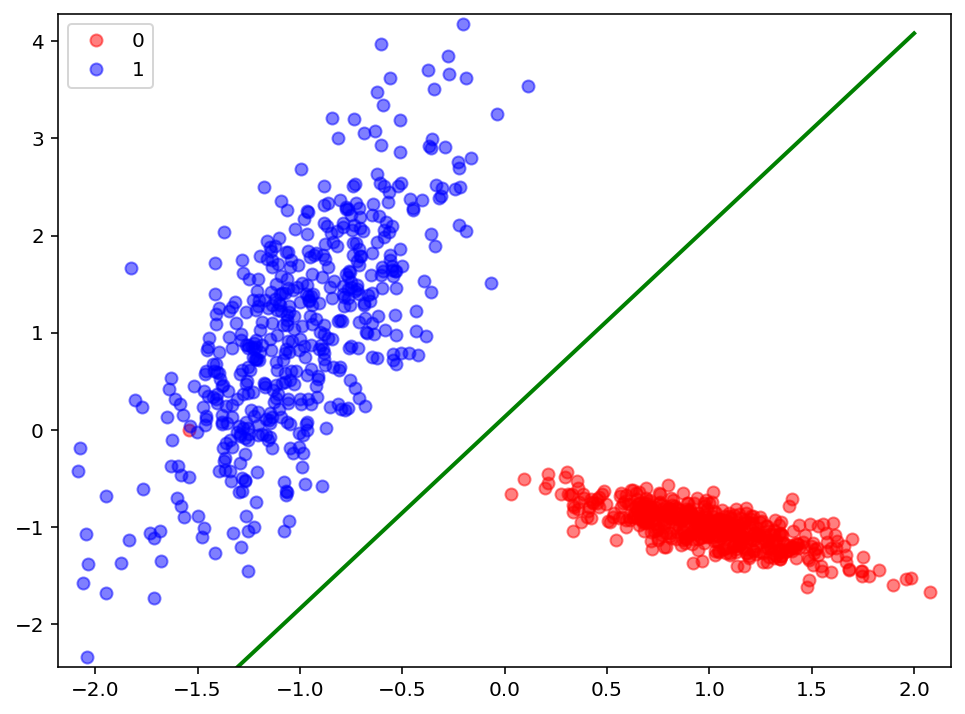

In [7]:
lr = LogisticRegression()
lr.fit(X, y)
print('LR coefficients:', lr.coef_)
print('LR intercept:', lr.intercept_)

plot_data(X, y)

limits = np.array([-2, 2])
boundary = -(lr.coef_[0][0] * limits + lr.intercept_[0]) / lr.coef_[0][1]
plt.plot(limits, boundary, "g-", linewidth=2)




As we can see the data is linearly separable. We will train a logistic regression model with Keras to predict the class membership of every input point. To keep things simple for now, we won't perform the standard practices of separating out the data to training and test sets, or performing k-fold cross-validation. We will see examples of these in the later sections on real datasets. 

Keras has great documentation at https://keras.io/ so I won't go into every single detail, but will give a general overview.

We will use the *Sequential* model API available [here](https://keras.io/getting-started/sequential-model-guide/). The Sequential model allows us to build deep neural networks, by stacking layers one top of another. Since we're now building a simple logistic regression model, we will have the input nodes directly connected to output node, without any hidden layers.

Quick clarification to disambiguate the terms being used. In neural networks literature, it's common to talk about input nodes and output nodes. This may sound strange at first glance, what's an input *node* per se? When we say input nodes, we're talking about the features of a given data point. In our case we have 2 features, the x and y coordinates of the points we plotted above, so we have 2 input nodes. You can simply think of it as a vector of 2 numbers. What about the output node then? The output of the logistic regression model is a single number, the probability of an input data point belonging to class 1. In other words $P(class=1)$. The probability of an input point belonging to class 0 is then $P(class=0) = 1 - P(class=1)$. So you can simply think of the output node as a vector with a single number between 0 and 1.

In Keras we don't add layers corresponding to input nodes, we only do for hidden nodes and output nodes. In our current model, we don't have any hidden layers, the input nodes are directly connected to the output node. This means our neural network definition in Keras will just have one layer with one node, corresponding to the output node.

The *Dense* function in Keras constructs a fully connected neural network layer, automatically initializing the weights as biases. It's a super useful function that you will see everywhere. The function arguments are defined as follows:
- *units*: The first argument, the number of nodes in this layer. Since we're constructing the output layer, and we said it has only one node, this value is 1.
- *input_shape*: The first layer in Keras models need to specify the input dimensions. The subsequent layers (which we don't have here but we will in later sections) don't need to specify this argument because Keras can infer their dimensions automatically. In this our input dimensionality is 2, the x and y coordinates. The input_shape parameter expects a vector, so in our case it's simply a tuple with one number.
- *activation*: The activation function of a logistic regression model is the *logistic* function, or altenatively called as *sigmoid*. We will explore different activation functions and where to use them and why in another tutorial.

We then compile the Keras model with the *compile* function. This creates the neural network model by configuring the learning process. The model hasn't been trained yet. Right now we're specifying the optimizer to use and the loss function to minimize. The arguments for the compile function are defined as follows:
- *optimizer*: Which optimizer to use in order to minimize the loss function. There are a lot of different optimizers, most of them based on gradient descent. We will explore different optimizers in another tutorial. For now we will use the *adam* optimizer, which is the one people prefer to use by default.
- *loss*: The loss function to minimize. Since we're building a binary 0/1 classifier, the loss function to minimize is *binary_crossentropy*. We will see other examples of loss functions in later sections.
- *metrics*: Which metric to report statistics on, for classification problems we set this as *accuracy*.

Now comes the fun part of actually training the model. The arguments are as follows:
- *x*: The input data, we defined it as *X* above. It contains the x and y coordinates of the input points
- *y*: Not to be confused with the y coordinate of the input points. In the tutorials you see online *y* refers the the labels, in our case the class we're trying to predict: 0 or 1.
- *verbose*: Prints out the loss and accuracy, set it to 1 to see the output.
- *epochs*: Number of times to go over the training data. When training models we pass through the training data not just once but multiple times.

The output of the fit method is the loss and accuracy at every epoch. We then plot it to see that the loss goes down to almost 0 over time, and the accuracy goes up to almost 1. Great! We have successfully trained our first neural network model with Keras. I know this was a long explanation, but I wanted to explain what we're doing in detail the first time. Once you understand what's going on and practice a couple of times, all this becomes second nature.

<Figure size 576x432 with 0 Axes>

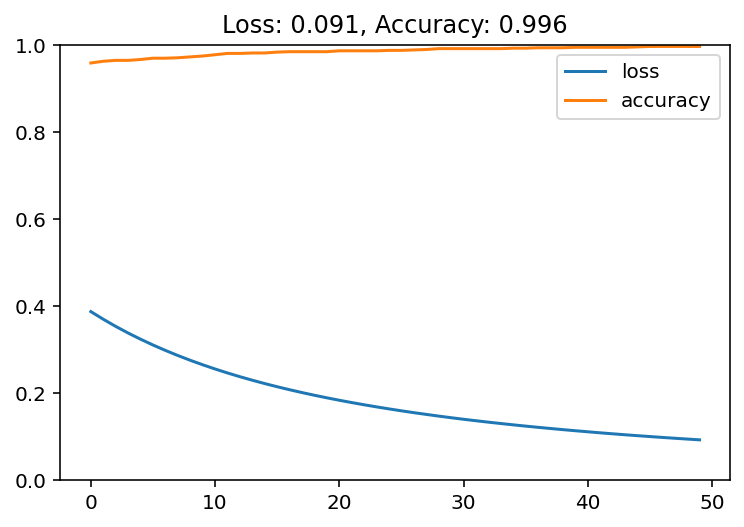

In [8]:
model = Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x=X, y=y, verbose=0, epochs=50)
plot_loss_accuracy(history)

A fancy plot of the decision boundary. The various shades of blue and red represent the probability of a hypothetical point in that area belonging to class 1. The top left area is classified as class 1, so the dark blue. The bottom right area is classified as class 0, so the dark red. And there is a transition around the decision boundary. I think this is a cool way to visualize the separator function the model is learning.

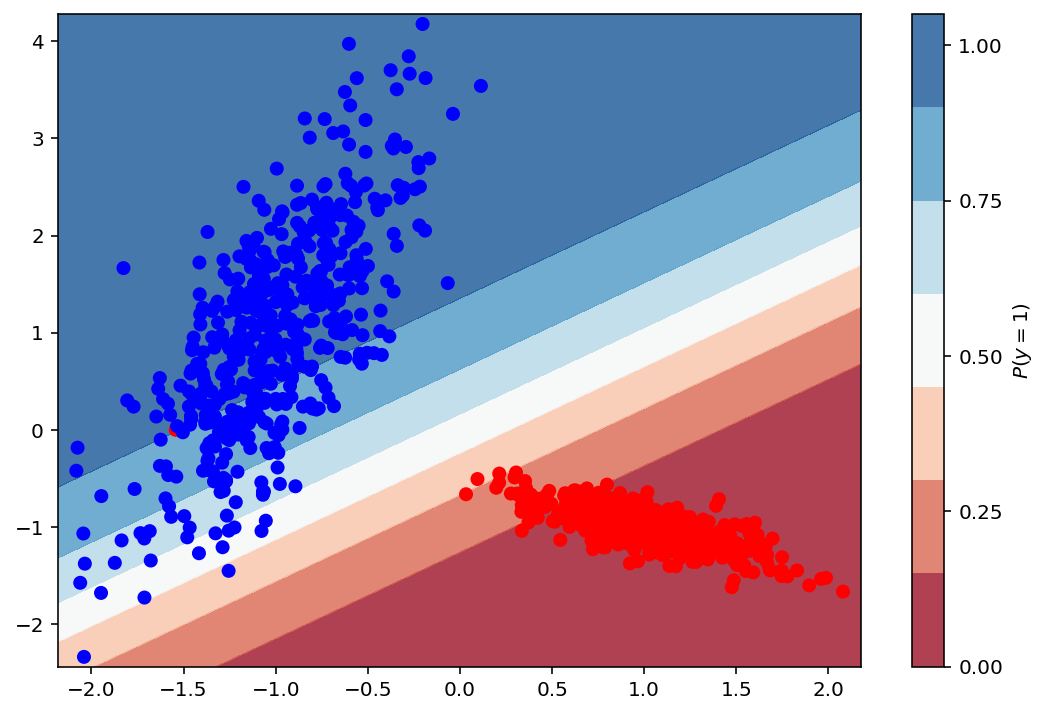

In [9]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

The classification report showing the precision and recall of our model.

In [12]:
# y_pred = model.predict_classes(X, verbose=0) Not available now
y_pred = (model.predict(X) > 0.5).astype("int32")
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       501
           1       1.00      0.99      1.00       499

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



The confusion matrix shows us how many classes were correctly classified vs misclassified. The numbers on the diagonal axis represent the number of correctly classified points, the rest are the misclassified ones. This particular matrix is not very interesting because the model correctly predicts the class of all but one point. We can see the misclassified point at the top right part of the confusion matrix, true value is class 0 but the predicted value is class 1.

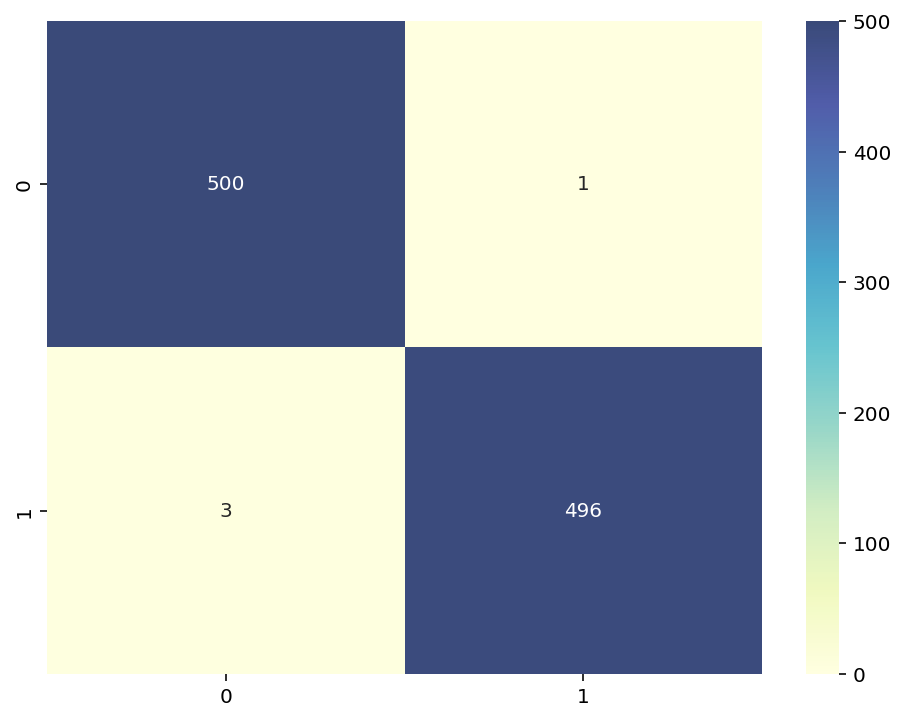

In [11]:
plot_confusion_matrix(model, X, y)

## Complex Data - Moons

The previous dataset was linearly separable, so it was trivial for our logistic regression model to separate the classes. Here is a more complex dataset which isn't linearly separable. The simple logistic regression model won't be able to distinguish between the classes.

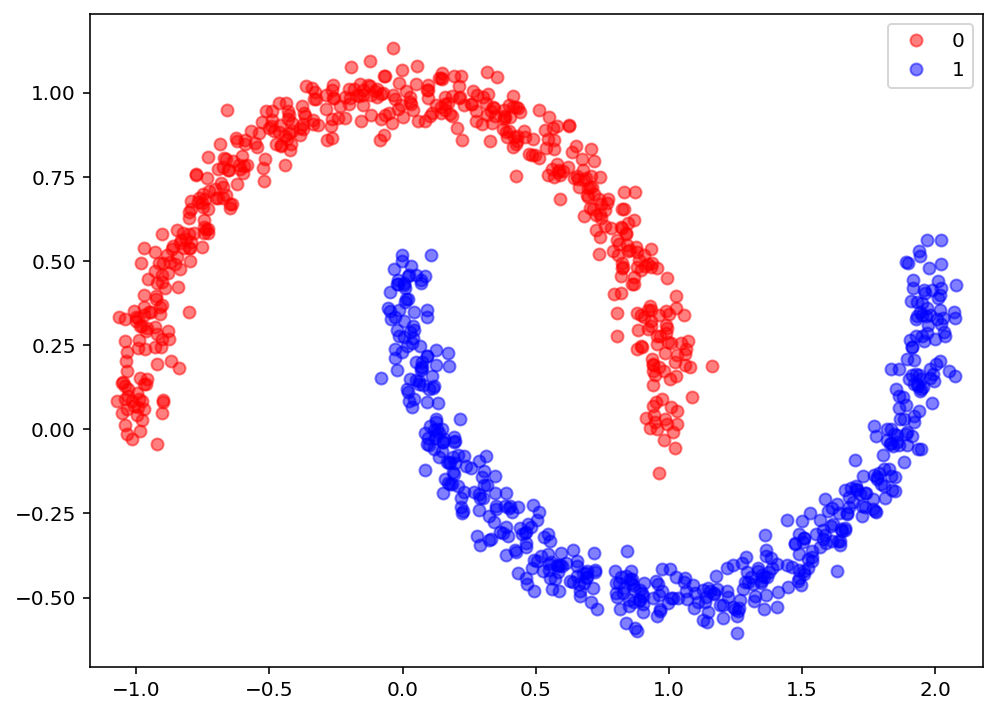

In [16]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
plot_data(X, y)

We're building the another logistic regression model with the same parameters as we did before.

<Figure size 576x432 with 0 Axes>

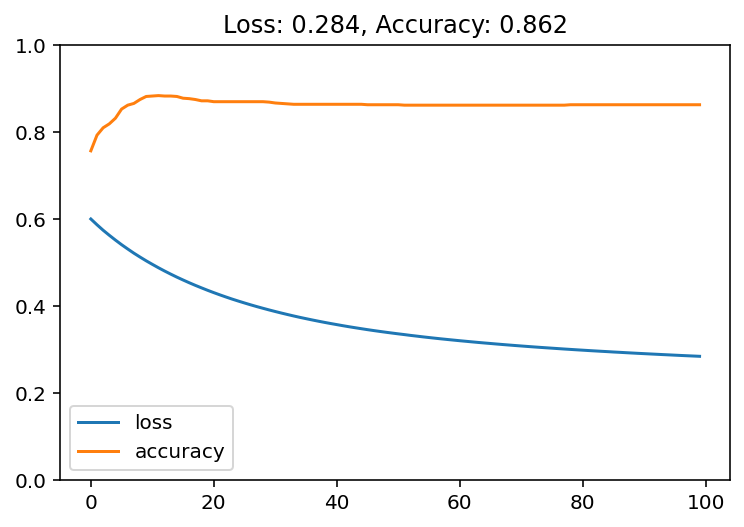

In [17]:
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history)

The current decision boundary doesn't look as clean as the one before. The model tried to separate out the classes from the middle, but there are a lot of misclassified points. We need a more complex classifier with a non-linear decision boundary, and we will see an example of that soon.

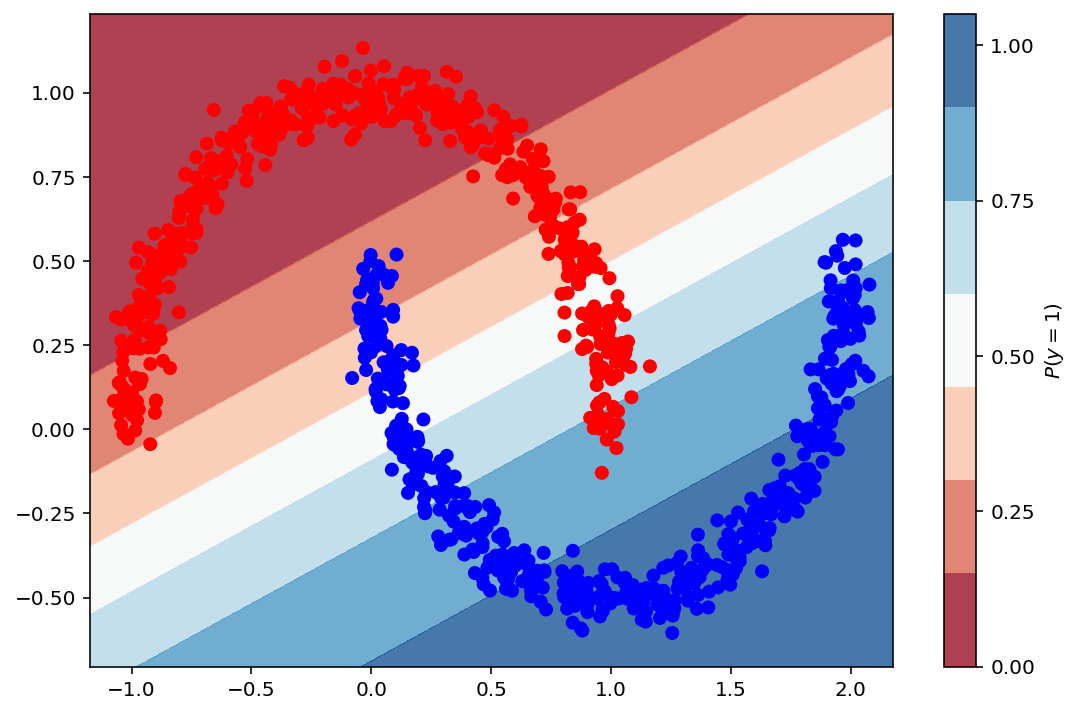

In [18]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

Precision of the model is 86%. It looks good on paper but we should be able to get 100% with a more complex model. You can imagine a curved decision boundary that will separate out the classes, and a complex model should be able to approximate that.

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       500
           1       0.86      0.86      0.86       500

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



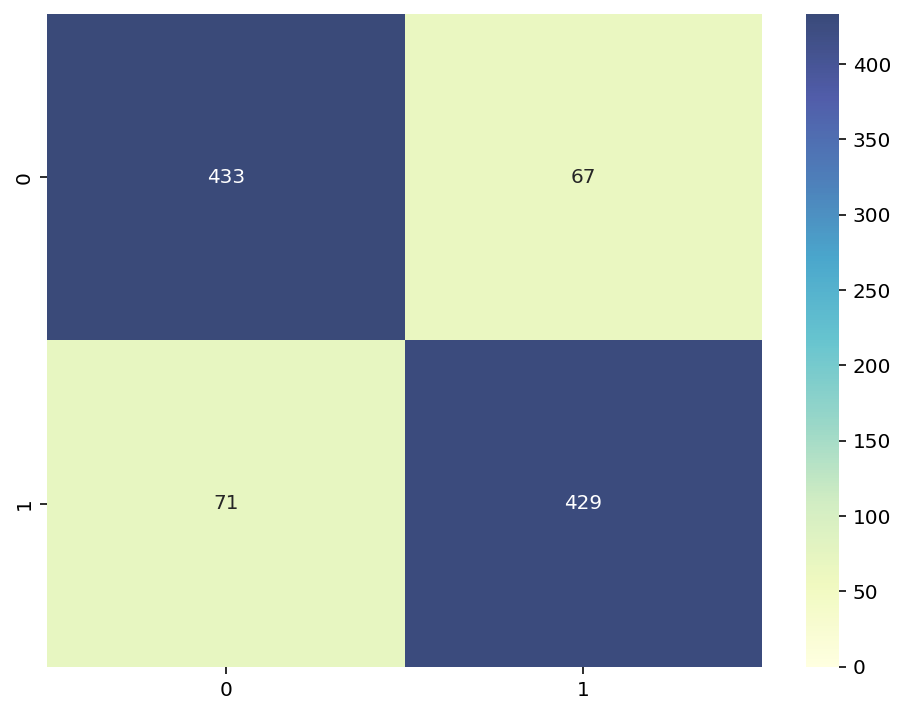

In [20]:
# y_pred = model.predict_classes(X, verbose=0) AttributeError: 'Sequential' object has no attribute 'predict_classes'
y_pred = (model.predict(X) > 0.5).astype("int32")
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

## Complex Data - Circles

Let's look at one final example where the liner model will fail.

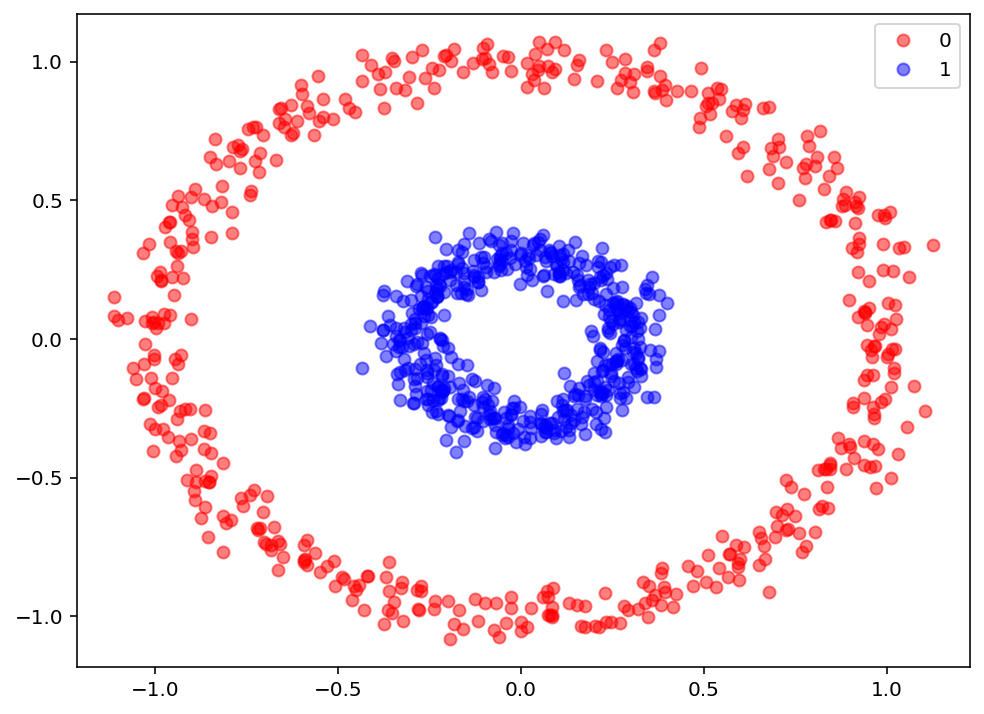

In [21]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)
plot_data(X, y)

Building the model with same parameters.

<Figure size 576x432 with 0 Axes>

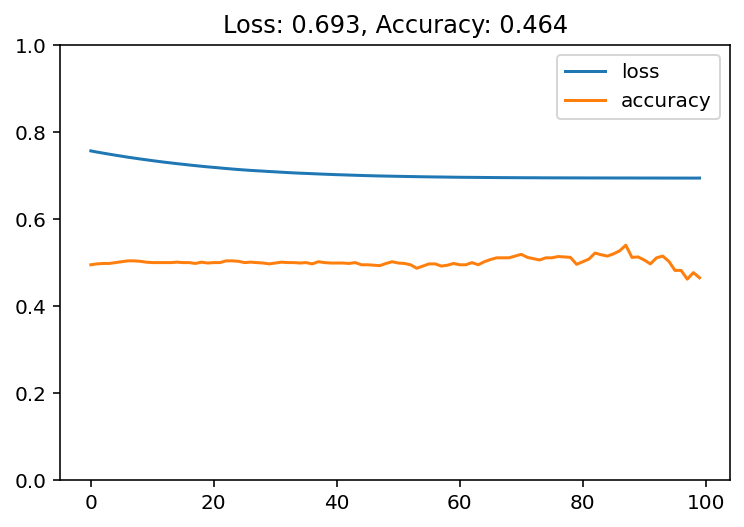

In [22]:
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history)

The decision boundary again passes from the middle of the data, but now we have much more misclassified points.

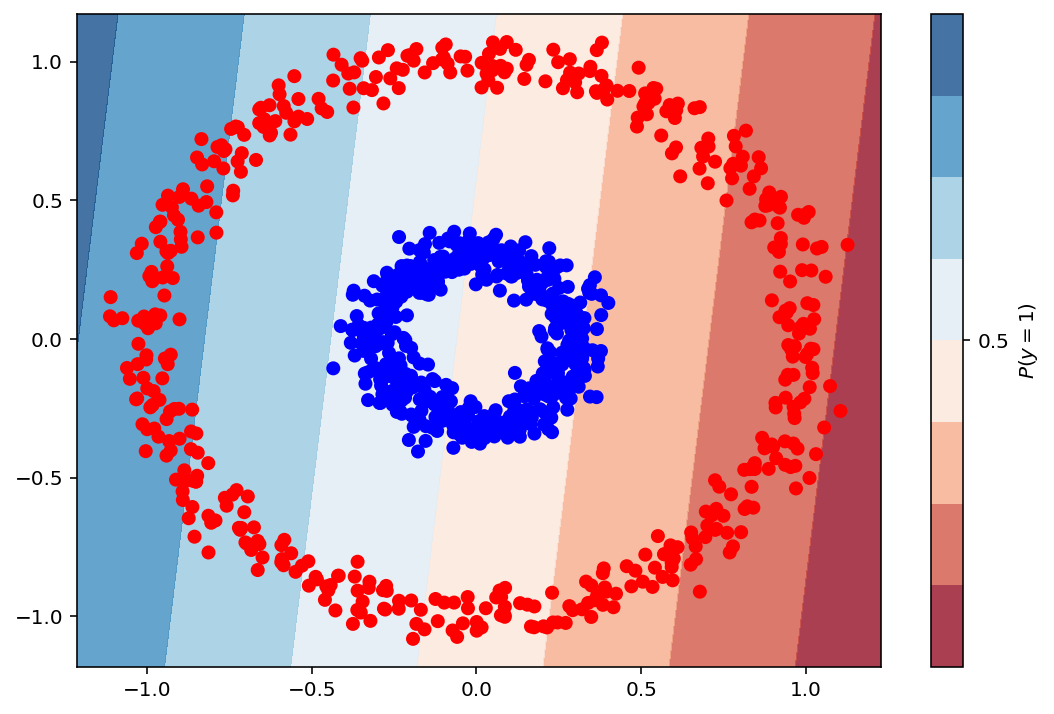

In [23]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

The accuracy is 51%. No matter where the model draws the linear line, it will misclassify half of the points, due to the nature of the dataset.

The confusion matrix we see here is an example one belonging to a poor classifier. Ideally we want confusion matrices like the ones we saw above. High numbers along the diagonals meaning that the classifier was right, and low numbers everywhere else where the classifier was wrong. In our visualization, the color blue represents the high numbers and yellow represents the low ones. So we would prefer to see blue on the diagonals and yellow everywhere else, blues everywhere is a bad sign meaning that our classifier is confused.

              precision    recall  f1-score   support

           0       0.48      0.52      0.50       500
           1       0.47      0.44      0.45       500

    accuracy                           0.48      1000
   macro avg       0.48      0.48      0.48      1000
weighted avg       0.48      0.48      0.48      1000



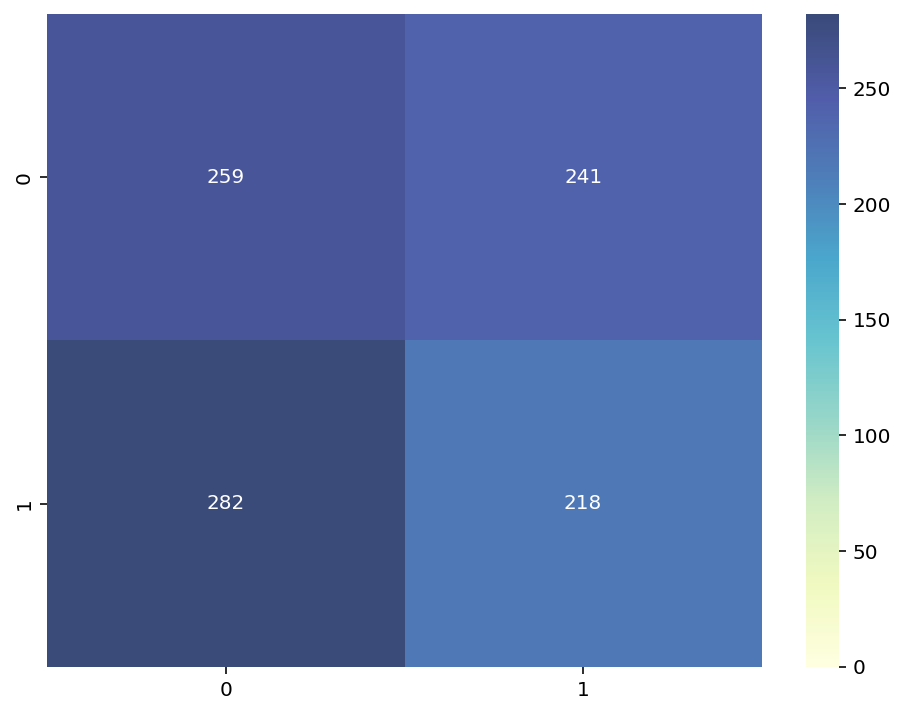

In [25]:
#y_pred = model.predict_classes(X, verbose=0)
y_pred = (model.predict(X) > 0.5).astype("int32")
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

# Training a Deep Neural Network

Now we will train a deep Artificial Neural Network (ANN) to better classify the datasets which the logistic regression model struggled, Moons and Circles datasets. We will also classify an even harder dataset of Sine Wave to demonstrate that ANNs can form really complex decision boundaries.

## Complex Data - Moons

While building Keras models for logistic regression above, we performed the following steps:
- Step 1: Define a Sequantial model.</p>
- Step 2: Add a Dense layer with sigmoid activation function. This was the only layer we needed.</p>
- Step 3: Compile the model with an optimizer and loss function.</p>
- Step 4: Fit the model to the dataset.</p>
- Step 5: Analyze the results: plotting loss/accuracy curves, plotting the decision boundary, looking at the classification report, and understanding the confusion matrix.</p>

While building a deep neural network, we only need to change step 2 such that, we will add several Dense layers one after another. The output of one layer becomes the input of the next. Keras again does most of the heavylifting of initializing the weights and biases, and connecting the output of one layer to the input of the next. We only need to specify how many nodes we want in that layer, and the activation function. It's as simple as that.

As you can see we first add a layer with 4 nodes and *tanh* activation function. Tanh is a commonly used activation function, and we'll learn more about it in another tutorial. We then add another layer with 2 nodes and again tanh activation. We finally add the last layer with 1 node and sigmoid activation. This is the final layer that we also used in the logistic regression model.

This is not a very deep ANN, it only has 3 layers: input layer, 1 hidden layer, and the output layer. But notice a couple of patterns:
- Output layer still uses the sigmoid activation function since we're working on a binary classification problem.
- Non-output layers use the tanh activation function. If we added more hidden layers, they would also have tanh activation.
- We have fewer number of nodes in each subsequent layer. It's common to have less nodes as we stack layers on top of one another.

We didn't build a very deep ANN here because it wasn't necessary. We already achieve perfect accuracy with this configuration.

<Figure size 576x432 with 0 Axes>

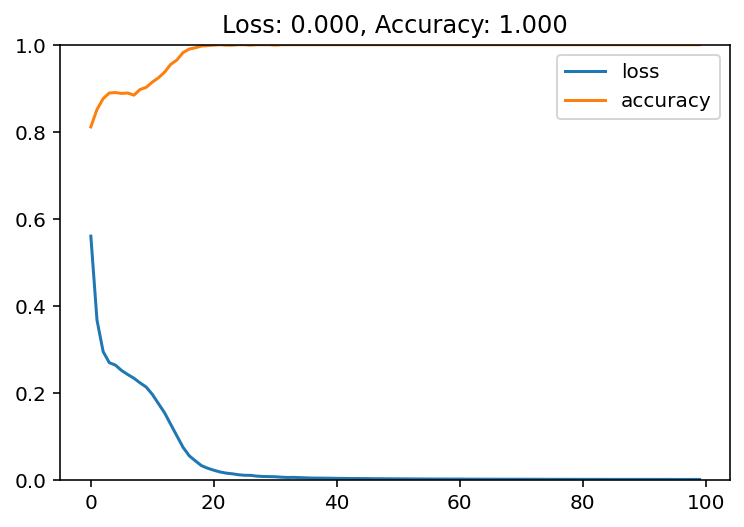

In [17]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)

model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)

plot_loss_accuracy(history)

The ANN is able to come up with a perfect separator to distinguish the classes.

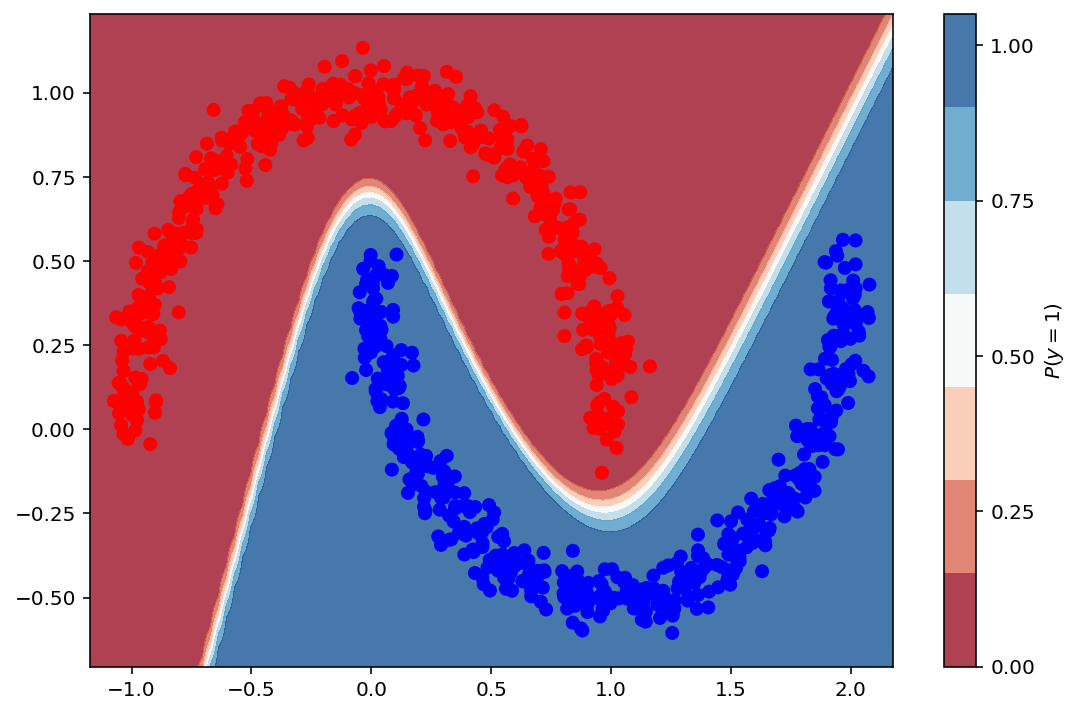

In [18]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

100% precision, nothing misclassified.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



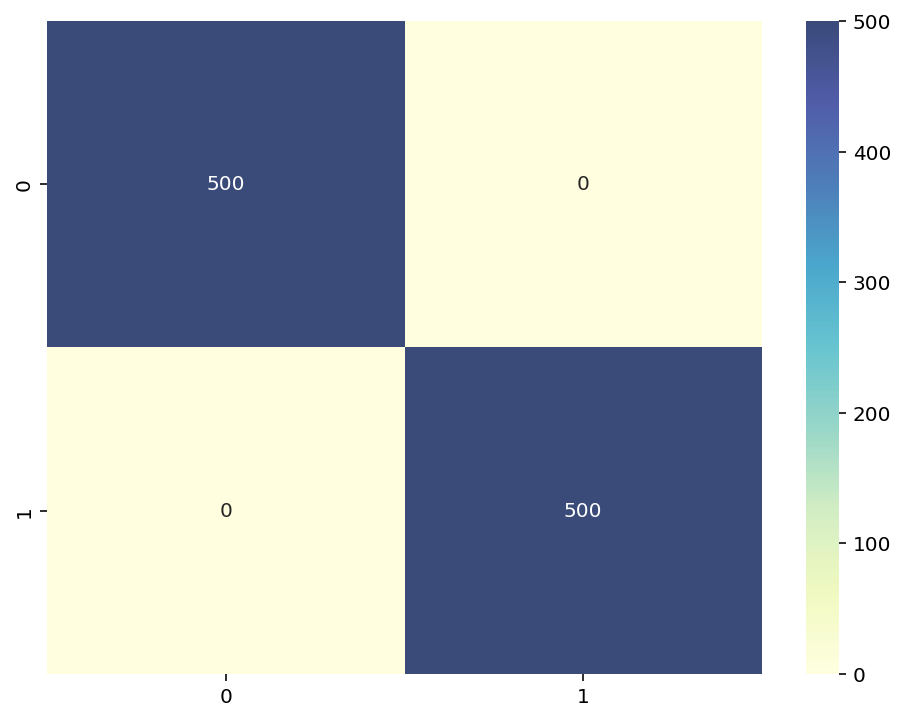

In [19]:
#y_pred = model.predict_classes(X, verbose=0)

y_pred = (model.predict(X) > 0.5).astype("int32")
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

## Complex Data - Circles

Now let's look at the Circles dataset, where the LR model achieved only 50% accuracy. The model is the same as above, we only change the input to the fit function. And we again achieve 100% accuracy.

<Figure size 576x432 with 0 Axes>

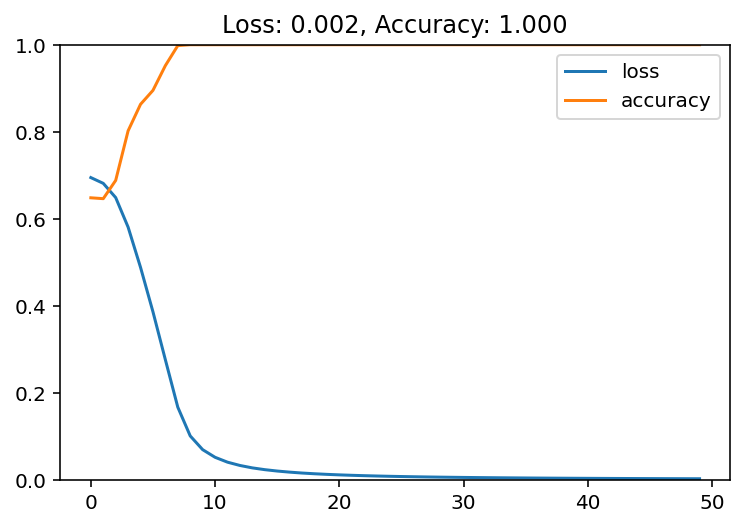

In [20]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)

model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=50)

plot_loss_accuracy(history)

Similarly the decision boundary looks just like one we would draw by hand ourselves. The ANN was able to figure out an optimal separator.

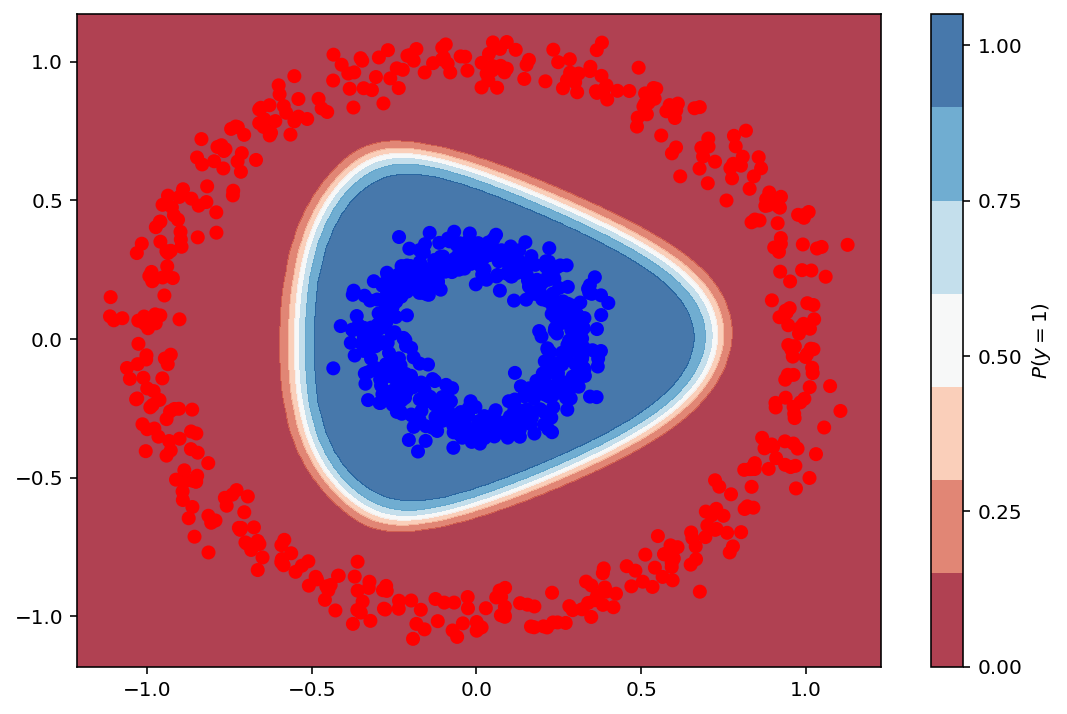

In [21]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

Just like above we get 100% accuracy.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



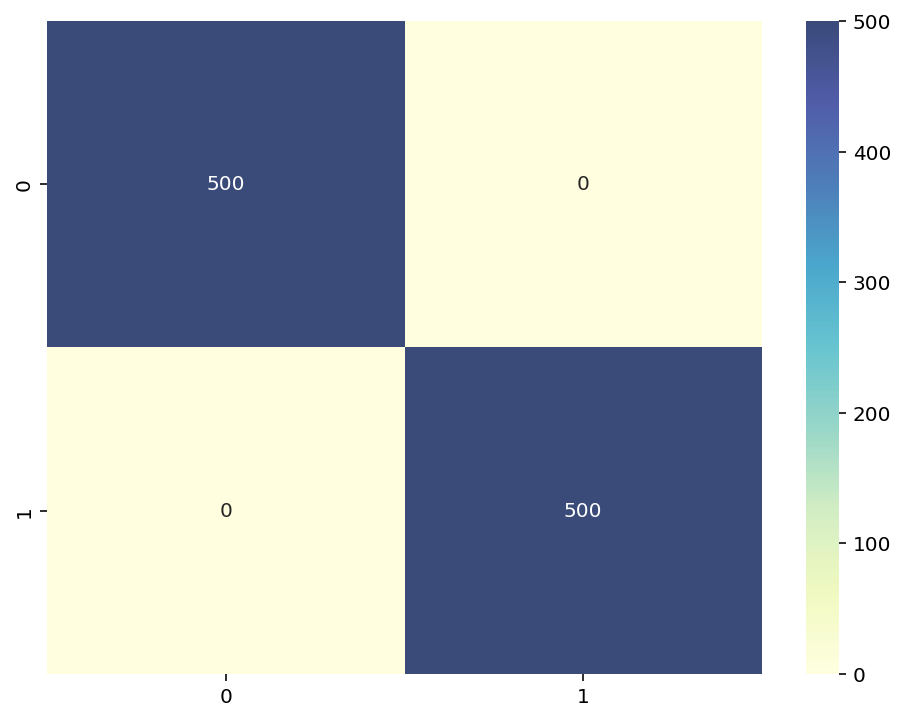

In [22]:
#y_pred = model.predict_classes(X, verbose=0)
y_pred = (model.predict(X) > 0.5).astype("int32")
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

## Complex Data - Sine Wave

Let's try to classify one final toy dataset, and then we will move on to real-world examples. In the previous sections, the classes were separable by one continuous decision boundary. The boundary had a complex shape, it wasn't linear, but still one decision boundary was enough. ANNs can draw arbitrary number of complex decision boundaries, and we will demonstrate that.

Let's create a sinusoidal dataset looking like the sine function, every up and down belongs to an alternating class. As we can see in the figure, a single decision boundary won't be able to separate out the classes. We will need a series of non-linear boundaries.

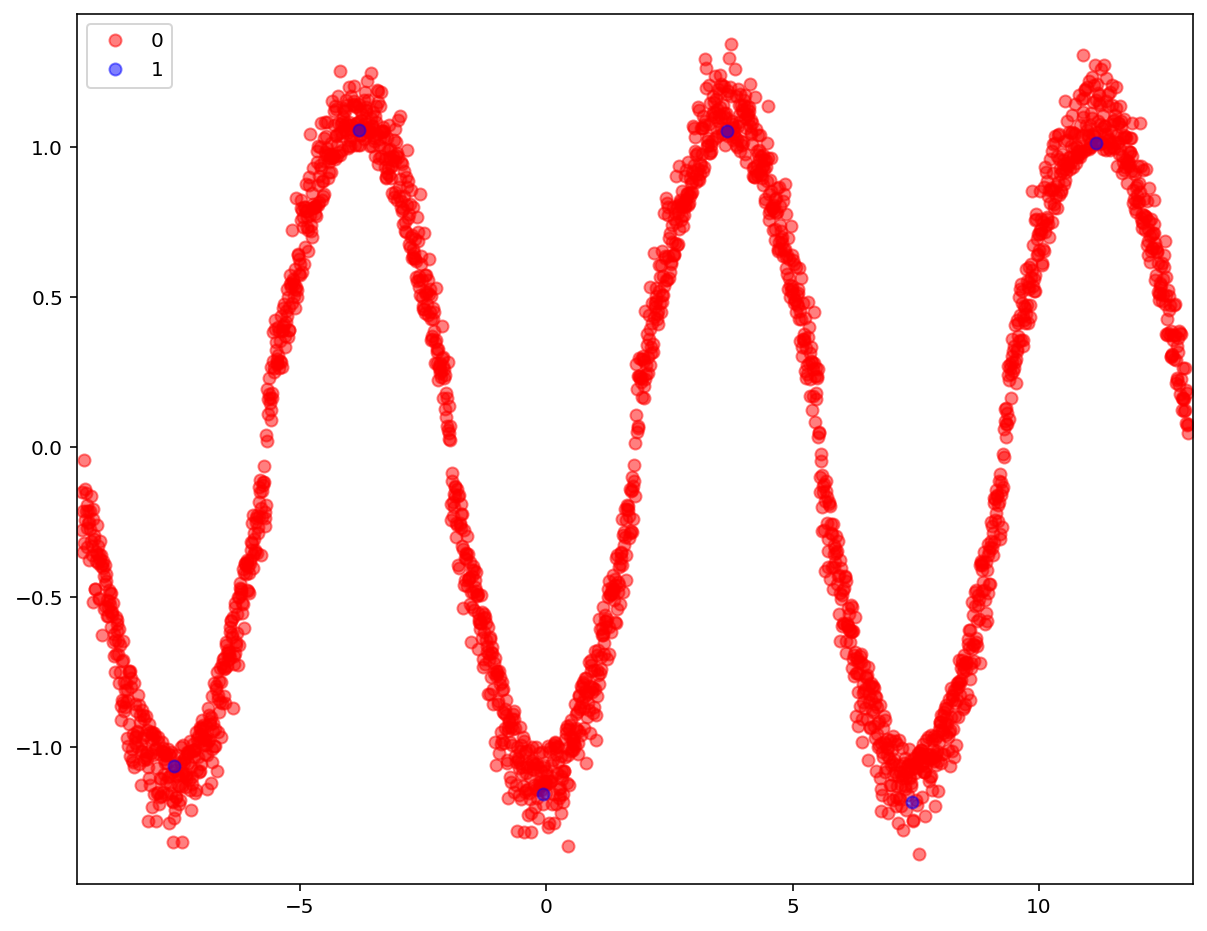

In [23]:
X, y = make_sine_wave()

plot_data(X, y, figsize=(10, 8))

Now we need a more complex model for accurate classification. So we have an input layer, 2 hidden layers, and an output layer. The number of nodes per layer has also increased to improve the learning capacity of the model. Choosing the right number of hidden layers and nodes per layer is more of an art than science, usually decided by trial and error.

<Figure size 576x432 with 0 Axes>

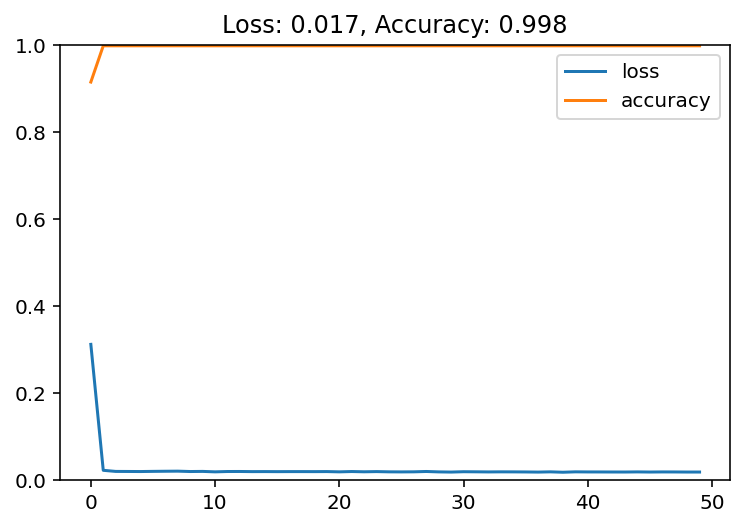

In [24]:
model = Sequential()
model.add(Dense(64, input_shape=(2,), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=50)

plot_loss_accuracy(history)

The ANN was able to model a pretty complex set of decision boundaries.

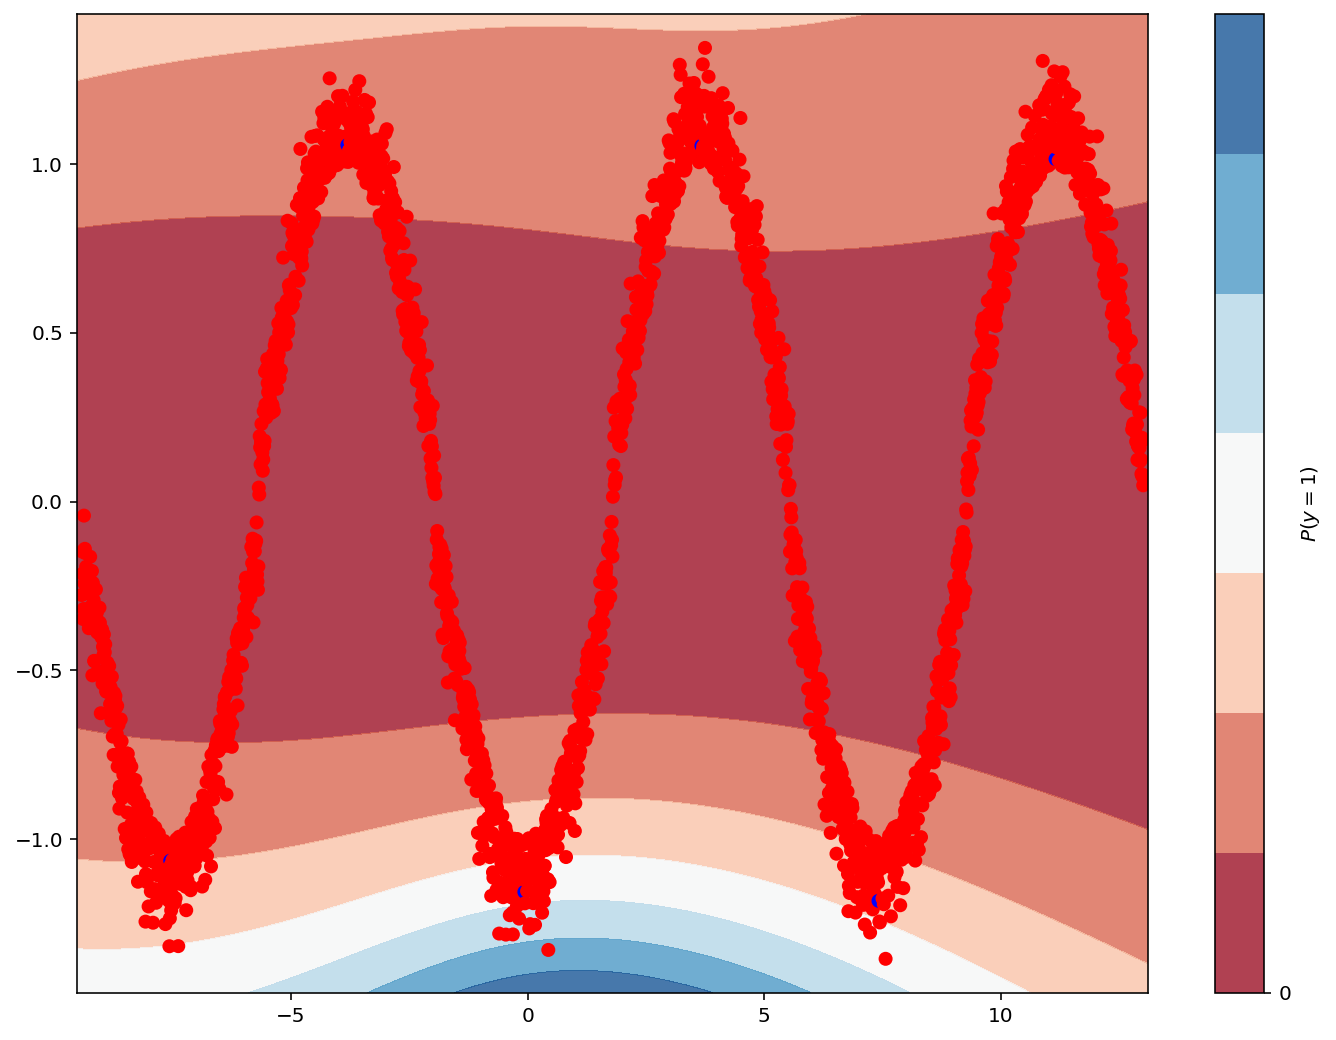

In [25]:
plot_decision_boundary(lambda x: model.predict(x), X, y, figsize=(12, 9))

Precision is 99%, we have 14 misclassified points out of 2400.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2394
           1       0.00      0.00      0.00         6

    accuracy                           1.00      2400
   macro avg       0.50      0.50      0.50      2400
weighted avg       1.00      1.00      1.00      2400



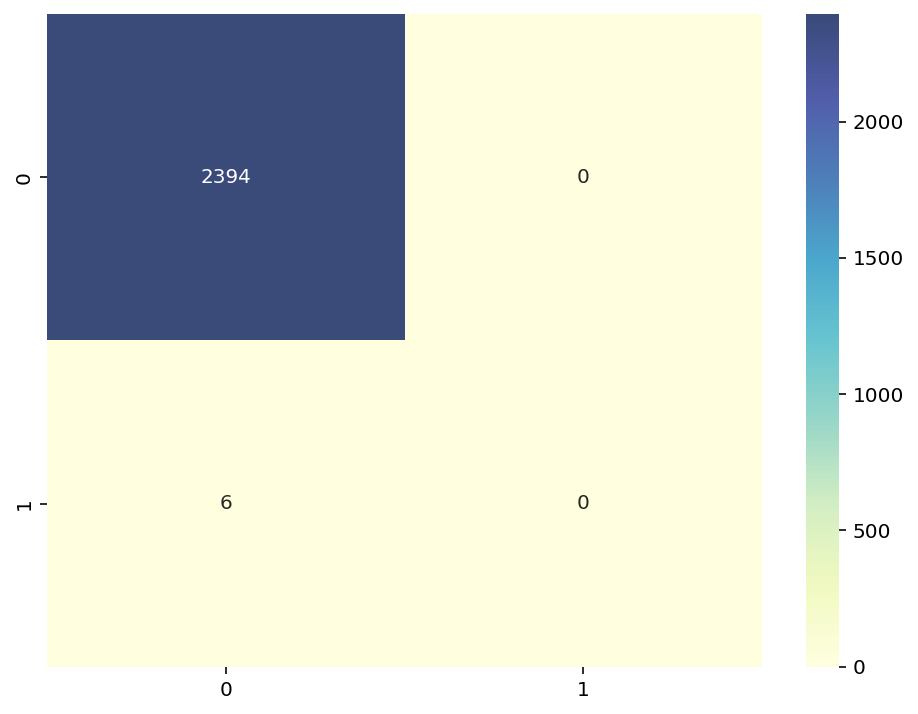

In [26]:
#y_pred = model.predict_classes(X, verbose=0)
y_pred = (model.predict(X) > 0.5).astype("int32")
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

# Multiclass Classification

In the previous sections we worked on a binary classification problem. Now we will take a look at a multi-class classification problem, where the number of classes is more than 2. We will pick 3 classes for demonstration, but our approach generalizes to any number of classes.

Here's how our dataset looks like, spiral data with 3 classes.

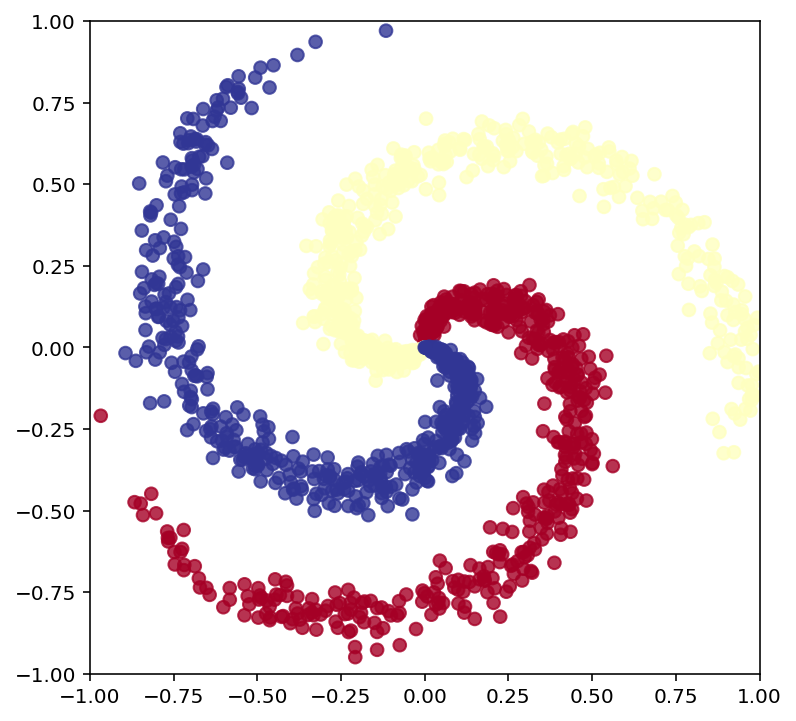

In [48]:
X, y = make_multiclass(K=3)

## Softmax Regression

As we saw above, Logistic Regression (LR) is a classification method for 2 classes. It works with binary labels 0/1. Softmax Regression (SR) is a generalization of LR where we can have more than 2 classes. In our current dataset we have 3 classes, represented as 0/1/2.

Building the model for SR is very similar to LR, for reference here's how we built our Logistic Regression model.

In [49]:
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=20)

And here's how how we will build the Softmax Regression model. There are a couple of differences, let's go over them one by one:
- Number of node in the dense layer: LR uses 1 node, where SR has 3 nodes. Since we have 3 classes it makes sense for SR to have 3 nodes. Then the question is, why does LR uses only 1 node, it has 2 classes so it appears like we should have used 2 nodes instead. The answer is, because we can achieve the same result with using only 1 node. As we saw above, LR models the probability of an example belonging to class one: $P(class=1)$. And we can calculate class 0 probability by: $1 - P(class=1)$. But when we have more than 2 classes, we need individual nodes for each class. Because knowing the probability of one class doesn't let us infer the probability of the other classes.
- Activation function: LR used sigmoid activation function, SR uses *softmax*. It scales the probability of the output neurons such that they sum up to 1. So in our case $P(class=0) + P(class=1) + P(class=2) = 1$. It doesn't do it in a naive way by dividing individual probabilities by the sum though, it uses the exponential function. So higher values get emphasized more and lower values get squashed.  We will talk in detail what softmax does in another tutorial. For now you can simply think of it as a normalization function which let's us interpret the output values as probabilities.
- Loss function: In a binary classification problem like LR, the loss function is binary_crossentropy. In the multiclass case like SR, the loss function is categorical_crossentropy. Going into the theory behind loss functions is beyond the scope of this tutorial. But for now only knowing this property is enough.
- Fit function: LR used the vector y directly in the fit function, which has just one column with binary 0/1 values. When we're doing SR the labels need to be in *one-hot* representation. In our case y_cat is a matrix with 3 columns, where all the values are 0 except for the one that represents our class, and that is 1.

It took a while to talk about all the differences between LR and SR, and it looks like as if there's a lot to learn. But again after some practice this will become a habit, and you won't even need to think about any of this.

After all this theory let's take a step back and remember that LR is a linear classifier. SR is also a linear classifier, but for multiple classes. So the "power" of the model hasn't changed, it's still a linear model. We just generalized LR to apply it to a multiclass problem.

Training the model gives us an accuracy of around 50%. The simplest possible technique which always predicts class 0 no matter what the input is would have an accuracy of 33%. This simple SR model is not much of an improvement over it, because the dataset is not linearly separable.

<Figure size 576x432 with 0 Axes>

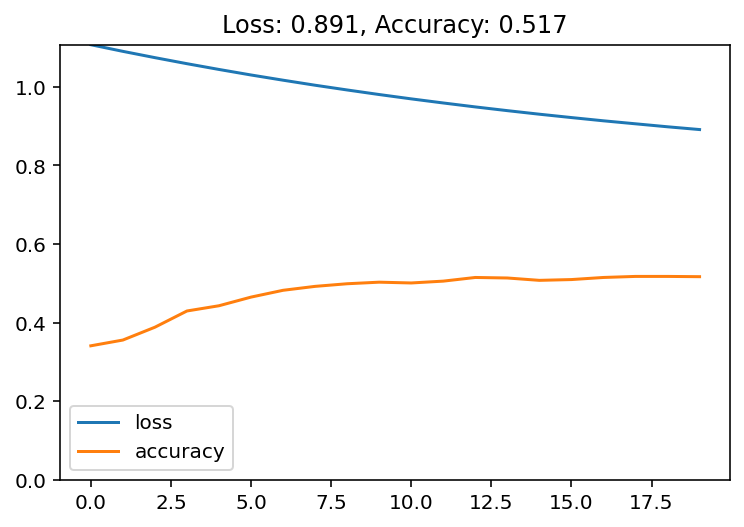

In [50]:
model = Sequential()
model.add(Dense(3, input_shape=(2,), activation='softmax'))

model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

y_cat = to_categorical(y)
history = model.fit(X, y_cat, verbose=0, epochs=20)
plot_loss_accuracy(history)

Looking at the decision boundary confirms that we still have a linear classifier. The lines look jagged due to floating point rounding but in reality they're straight.

In [51]:
plot_multiclass_decision_boundary(model, X, y)

ValueError: cannot reshape array of size 30603 into shape (101,101)

We see the precision and recall corresponding to the 3 classes. And the confusion matrix is all over the place. Clearly this is not an optimal classifier.

In [53]:
#y_pred = model.predict_classes(X, verbose=0)
y_pred = (model.predict(X) > 0.5).astype("int32")

y_pred = (model.predict(X) > 0.5).astype("int32")
print(classification_report(y, y_pred,labels=[1, 2, 3]))
plot_confusion_matrix(model, X, y)

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

## Deep Neural Network

Now let's build a deep ANN for multiclass classification. Remember that the changes going from LR to deep ANN was minimal. We only needed to add more Dense layers. We'll do the same thing again. Adding a couple of Dense layers with tanh activation function, and decreasing number of nodes per layer.

Notice that the output layer still has 3 nodes, and uses the softmax activation. The loss function also didn't change, still categorical_crossentropy. These won't change going from a linear model to a deep ANN, since the problem definition hasn't changed. We're still working on multiclass classification. We're now using a more powerful model, and that power comes from adding more layers to our neural network.

We achieve 99% in just a couple of epochs.

<Figure size 576x432 with 0 Axes>

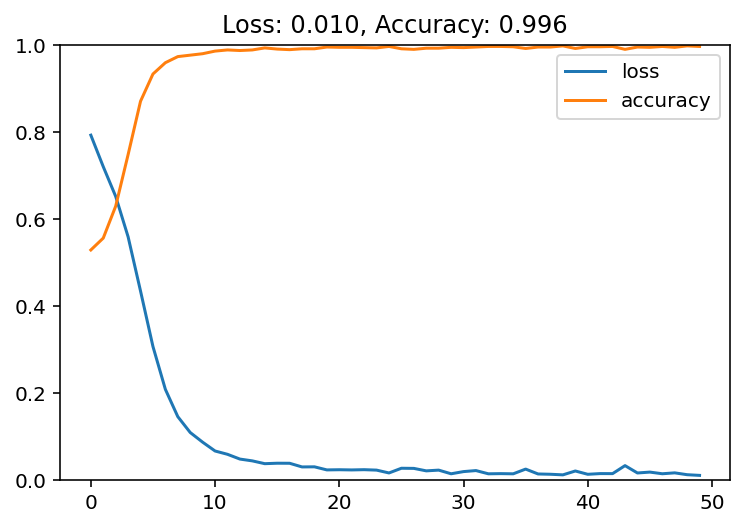

In [32]:
model = Sequential()
model.add(Dense(128, input_shape=(2,), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(3, activation='softmax'))

model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

y_cat = to_categorical(y)
history = model.fit(X, y_cat, verbose=0, epochs=50)
plot_loss_accuracy(history)

The decision boundary is non-linear.

In [33]:
plot_multiclass_decision_boundary(model, X, y)

ValueError: cannot reshape array of size 30603 into shape (101,101)

We got almost 100% accuracy. We’ve totally misclassified 6 points out of 1500.

In [35]:
#y_pred = model.predict_classes(X, verbose=0)
y_pred = (model.predict(X) > 0.5).astype("int32")
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets